#Шаг 1. Подготовка данных

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pylab import rc, plot

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

cmap = sns.diverging_palette(220, 10, as_cmap=True) # цветовая палитра для seaborn 

%matplotlib inline
pd.get_option("display.max_columns")

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

In [7]:
# параметры
N, M  = 5, 546*6

# Генерация шести классов, каждый из которых представим в виде двух признаков
X, y = make_blobs(n_samples=M, centers=N, n_features=2,
                  cluster_std = 1.8,
                   random_state=2282)
 
# first_feature, second_feature - признаки; target_value - метка класса
columns = {'first_feature': X[:, 0], 'second_feature': X[:, 1], 'target_value': y}
data = pd.DataFrame(data = columns)
data.head(10)

,first_feature,second_feature,target_value
0,4.074839,-2.358763,3
1,-5.550052,5.679711,4
2,-0.977990,-9.846339,2
3,0.155146,-8.141059,2
4,-0.361076,3.658810,0
5,-7.671757,2.472925,4
6,0.923465,4.982249,0
7,6.051846,0.933882,3
8,1.218833,-9.705989,2
9,8.252435,0.412056,1


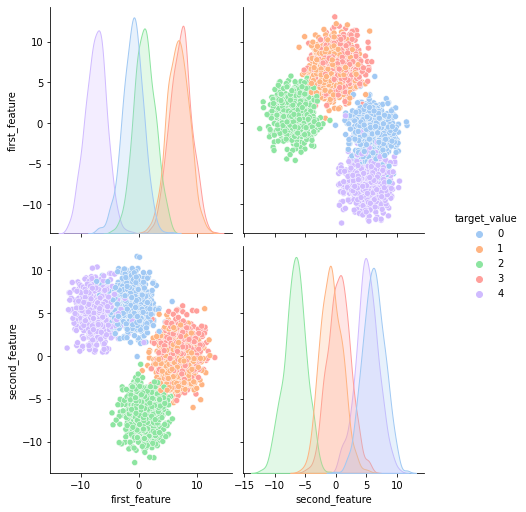

In [8]:
# визуализация данных

g = sns.pairplot(data, hue='target_value', palette='pastel')
g.fig.set_size_inches(7.5,7.5)

#Шаг 2. Описание функций.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [13]:
# параметры для дерева решений
params = dict(max_depth = np.linspace(1, 32, 32, endpoint=True), 
                      min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True),
                      min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
                      )
# признаки и целевая переменная (метка класса)
values, targets = data.drop('target_value', axis=1), data.target_value
# разбиение на train-test 
x_train, x_test, y_train, y_test = train_test_split(data.drop('target_value', axis=1), data.target_value, test_size=0.5, stratify=data.target_value, random_state=42)

In [14]:
# использую refit='precision_macro', так как precision = TP / (TP + FP)
# мне необходимо минимизировать ошибку первого рода (FP)
# чем меньше значение FP, тем больше значение precision
# чем выше precision, тем меньше ложных пропусков -> меньше ошибка первого рода

def do_random_search(model=None, refit='precision_macro', params=params, values=values, tagrets=targets):

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    random_search_cv = RandomizedSearchCV(model, params, scoring=['f1_macro','precision_macro', 'recall_macro'], 
                                          n_jobs=4, cv=cv, verbose=3, random_state=42, refit=refit)
    random_search = random_search_cv.fit(values, targets)
    print('Best params for {}'.format(refit))
    print(random_search.best_params_)

In [15]:
def do_grid_search(model=None, refit='precision_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test):
    
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    grid_search = GridSearchCV(model, params, scoring=['f1_macro','precision_macro', 'recall_macro'], 
                                n_jobs=4, cv=cv, verbose=3, refit=refit) 
    grid_search.fit(x_train.values, y_train.values)
    y_pred = grid_search.predict(x_test.values)
    print('Best params for {}'.format(refit))
    print(grid_search.best_params_)

In [16]:
def print_result(y_test=y_test, pred=None):
  
  print("classification report: \n", classification_report(y_test, pred))
  conf_matrix = confusion_matrix(y_test, pred)
  print("Матрица ошибок: \n", conf_matrix, "\n")
  sns.heatmap(conf_matrix, cmap = cmap, annot=True)

#Шаг 4. Дерево решений

In [17]:
dtree = DecisionTreeClassifier(random_state=42)
score = cross_val_score(dtree, data.drop('target_value', axis=1), data.target_value, cv=9, scoring='precision_macro')
print('Средняя оценка precision без настройки гиперпараметров: ', np.mean(score))

Средняя оценка precision без настройки гиперпараметров:  0.8033358632953309


classification report: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       328
           1       0.59      0.59      0.59       328
           2       0.98      0.98      0.98       327
           3       0.60      0.59      0.60       328
           4       0.93      0.93      0.93       327

    accuracy                           0.80      1638
   macro avg       0.80      0.80      0.80      1638
weighted avg       0.80      0.80      0.80      1638

Матрица ошибок: 
 [[301   2   1   2  22]
 [  4 193   4 127   0]
 [  0   5 322   0   0]
 [  5 128   0 195   0]
 [ 22   0   0   0 305]] 



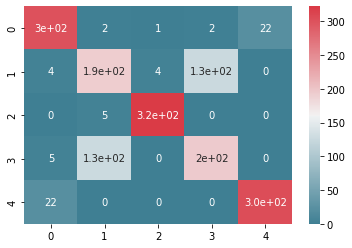

In [18]:
dtree.fit(x_train, y_train)
pred = dtree.predict(x_test)
print_result(y_test=y_test, pred=pred)

#Шаг 5. Дерево решений с настройкой гиперпараметров при помощи RandomSearch

In [19]:
%%time
do_random_search(model=dtree, refit='precision_macro', params=params, values=values, tagrets=targets)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for precision_macro
{'min_samples_split': 0.05000000000000001, 'min_samples_leaf': 0.08, 'max_depth': 32.0}
CPU times: user 361 ms, sys: 66.8 ms, total: 428 ms
Wall time: 3.83 s


# <center> **Значения гиперпараметров для дерева решений полученные при помощи RandonSearch** </center>

RandomSearch дал следующие значения гиперпараметров:

**{'min_samples_split': 0.05000000000000001, 'min_samples_leaf': 0.08, 'max_depth': 32.0}**

Затраченное время:

* CPU times: user 171 ms, sys: 22.1 ms, total: 193 ms
* Wall time: 2.07 s

In [21]:
dtree_random = DecisionTreeClassifier(random_state=42, max_depth=32.0, min_samples_leaf=0.08, min_samples_split=0.05000000000000001)

score = cross_val_score(dtree_random, data.drop('target_value', axis=1), data.target_value, cv=9, scoring='precision_macro')
print('Средняя оценка precision с настройкой гиперпараметров RandomSearch: ', np.mean(score))

Средняя оценка precision с настройкой гиперпараметров RandomSearch:  0.8146418505112568


# <center> **Отчет о классификации, при использованнии гиперпараметров для дерева решений, полученных при помощи RandonSearch** </center>

classification report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       328
           1       0.67      0.51      0.58       328
           2       0.94      0.95      0.95       327
           3       0.64      0.76      0.69       328
           4       0.93      0.97      0.95       327

    accuracy                           0.82      1638
   macro avg       0.82      0.82      0.82      1638
weighted avg       0.82      0.82      0.82      1638

Матрица ошибок: 
 [[302   0   0   3  23]
 [  6 166  17 139   0]
 [ 11   4 310   0   2]
 [  0  78   2 248   0]
 [ 11   0   0   0 316]] 



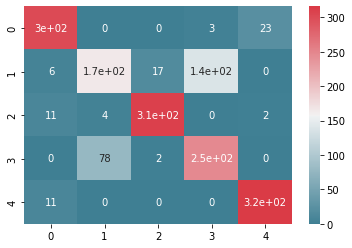

In [22]:
dtree_random.fit(x_train, y_train)
pred_random_search = dtree_random.predict(x_test)
print_result(y_test=y_test, pred=pred_random_search)

#Шаг 6. Дерево решений с настройкой гиперпараметров при помощи GridSearch

# <center> **Значения гиперпараметров для дерева решений полученные при помощи GridSearch** </center>

In [24]:
%%time
do_grid_search(model=dtree, refit='precision_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
Best params for precision_macro
{'max_depth': 4.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}
CPU times: user 23.8 s, sys: 604 ms, total: 24.4 s
Wall time: 1min 37s


GridSearch дал следующие значения гиперпараметров:

**{'max_depth': 4.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}**

Затраченное время:

* CPU times: user 23.8 s, sys: 604 ms, total: 24.4 s
* Wall time: 1min 37s

In [25]:
dtree_grid = DecisionTreeClassifier(random_state=42, max_depth=4.0, min_samples_leaf=0.01, min_samples_split=0.01)

score = cross_val_score(dtree_grid, values, targets, cv=9, scoring='precision_macro')
print('Средняя оценка precision с настройкой гиперпараметров GridSearch: ', np.mean(score))

Средняя оценка precision с настройкой гиперпараметров GridSearch:  0.8239527217549711


# <center> **Отчет о классификации, при использованнии гиперпараметров для дерева решений, полученных при помощи GridSearch** </center>

classification report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       328
           1       0.67      0.55      0.60       328
           2       0.99      0.93      0.96       327
           3       0.64      0.76      0.69       328
           4       0.93      0.97      0.95       327

    accuracy                           0.82      1638
   macro avg       0.83      0.82      0.82      1638
weighted avg       0.83      0.82      0.82      1638

Матрица ошибок: 
 [[302   0   0   3  23]
 [  6 180   3 139   0]
 [ 11   9 305   0   2]
 [  0  80   0 248   0]
 [ 11   0   0   0 316]] 



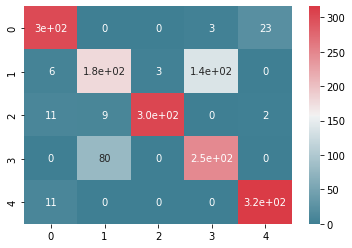

In [26]:
dtree_grid.fit(x_train, y_train)
pred_grid_search = dtree_grid.predict(x_test)
print_result(y_test, pred_grid_search)

#Шаг 7. Построение k ближайших соседей.

In [27]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)

score = cross_val_score(knn, values, targets, cv=9, scoring='precision_macro')
print('Средняя оценка precision без настройки гиперпараметров: ', np.mean(score))

Средняя оценка precision без настройки гиперпараметров:  0.8146224661168927


classification report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       328
           1       0.59      0.62      0.61       328
           2       1.00      0.98      0.99       327
           3       0.61      0.58      0.59       328
           4       0.94      0.96      0.95       327

    accuracy                           0.82      1638
   macro avg       0.82      0.82      0.82      1638
weighted avg       0.82      0.82      0.82      1638

Матрица ошибок: 
 [[309   0   0   0  19]
 [  1 205   1 121   0]
 [  0   6 321   0   0]
 [  1 138   0 189   0]
 [ 14   0   0   0 313]] 



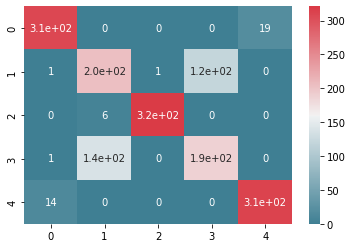

In [28]:
print_result(y_test, pred_knn)

In [29]:
# параметры для kNN
params = dict(n_neighbors = np.array(range(1, 15, 1)), 
              weights = ['uniform', 'distance'],
              algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'], 
              p = [1, 2],
              metric = ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'seuclidean', 'mahalanobis']
              )

#Шаг 8. Построение k ближайших соседей с настройкой гиперпараметров при помощи RandomSearch.

# <center> **Значения гиперпараметров для k ближайших соседей полученных при помощи RandonSearch** </center>

In [31]:
%%time
do_random_search(model=knn, refit='precision_macro', params=params, values=values, tagrets=targets)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for precision_macro
{'weights': 'uniform', 'p': 1, 'n_neighbors': 10, 'metric': 'minkowski', 'algorithm': 'brute'}
CPU times: user 240 ms, sys: 5.38 ms, total: 245 ms
Wall time: 1.6 s


RandomSearch дал следующие значения гиперпараметров:

**{'weights': 'uniform', 'p': 1, 'n_neighbors': 10, 'metric': 'minkowski', 'algorithm': 'brute'}**

Затраченное время

* CPU times: user 240 ms, sys: 5.38 ms, total: 245 ms
* Wall time: 1.6 s

In [32]:
knn_random = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=10, metric='minkowski', algorithm='brute')
knn_random.fit(x_train, y_train)
pred_knn_random = knn_random.predict(x_test)

score = cross_val_score(knn_random, values, targets, cv=9, scoring='precision_macro')
print('Средняя оценка precision с настройкой гиперпараметров (RandomSearch): ', np.mean(score))

Средняя оценка precision с настройкой гиперпараметров (RandomSearch):  0.8220780083393409


# <center> **Отчет о классификации, при использованнии гиперпараметров для k ближайших соседей, полученных при помощи RandomSearch** </center>

classification report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       328
           1       0.62      0.70      0.66       328
           2       0.99      0.98      0.99       327
           3       0.67      0.58      0.62       328
           4       0.94      0.94      0.94       327

    accuracy                           0.83      1638
   macro avg       0.83      0.83      0.83      1638
weighted avg       0.83      0.83      0.83      1638

Матрица ошибок: 
 [[310   0   0   0  18]
 [  1 229   3  95   0]
 [  0   5 322   0   0]
 [  0 137   0 191   0]
 [ 20   0   0   0 307]] 



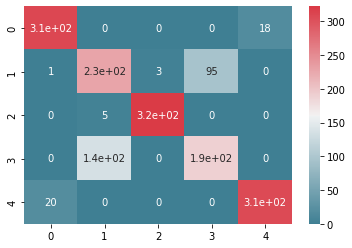

In [33]:
print_result(y_test, pred_knn_random)

#Шаг 9. Построение k ближайших соседей с настройкой гиперпараметров при помощи GridSearch.

# <center> **Значения гиперпараметров для k ближайших соседей полученных при помощи GridSearch** </center>

In [35]:
%%time
do_grid_search(model=knn, refit='precision_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
Best params for precision_macro
{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 12, 'p': 2, 'weights': 'uniform'}
CPU times: user 10.6 s, sys: 379 ms, total: 11 s
Wall time: 1min 13s


In [38]:
knn_grid = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=12, metric='minkowski', algorithm='auto')
knn_grid.fit(x_train, y_train)
pred_knn_grid = knn_grid.predict(x_test)

score = cross_val_score(knn_grid, values, targets, cv=9, scoring='precision_macro')
print('Средняя оценка precision с настройкой гиперпараметров (GridSearchCV): ', np.mean(score))

Средняя оценка precision с настройкой гиперпараметров (GridSearchCV):  0.8241712009716529


# <center> **Отчет о классификации, при использованнии гиперпараметров для k ближайших соседей, полученных при помощи GridSearch** </center>

classification report: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       328
           1       0.61      0.68      0.65       328
           2       0.99      0.98      0.99       327
           3       0.66      0.58      0.62       328
           4       0.94      0.94      0.94       327

    accuracy                           0.83      1638
   macro avg       0.83      0.83      0.83      1638
weighted avg       0.83      0.83      0.83      1638

Матрица ошибок: 
 [[309   0   0   0  19]
 [  2 224   3  99   0]
 [  0   5 322   0   0]
 [  0 137   0 191   0]
 [ 20   0   0   0 307]] 



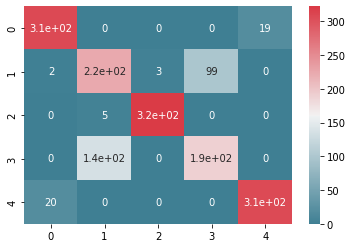

In [37]:
print_result(y_test, pred_knn_grid)

#Шаг 10. **Обощенние полученных результатов и их интерпритация.**

- Сначала сравним результаты, полученные classification report (рассмотрим precision).

**Дерево решений**: RandomSearch дал увеличение precision для трех классов (0, 1, 3), за исключением четвертого класса (recall без гиперпараметров: 0.84, с гиперпараметрами: 0.79), а так же пятого который остался без изменений. GridSearchCV дал увелечение precision для кажого класса, за исключением последнего, который остался без изменений. Однако, время работы RandomSearchCV намного меньше, чем время работы GridSearchCV. Это связано с тем, что поиск по сетке тратит слишком много времени на оценку бесперспективных областей пространства гиперпараметров, так как он оценивает каждую отдельную комбинацию в сетке. Случайный поиск, напротив, лучше справляется с исследованием пространства поиска, поэтому обычно может найти хорошую комбинацию гиперпараметров за гораздо меньшее количество итераций.

**kNN**: Здесь также видим иную ситуацию, свои значения увеличили только 2 класса: 1 и 3, у 0 и 2 они уменьшились, а у 4 оно осталось без изменений. Аналогичная ситуация и для случайного поиска.
- Сравним результаты, полученные в результате оценки кросс-валидацией.

Для обоих алгоритмов также вычислялось среднее значение precision, и в каждом случае выделяется тенденция роста качества ( без настройки < настройка случайным поиском < настройка сеткой).